# Single queue simulation

Companion blog post: [Simulating an M/M/1 queue in Python](https://medium.com/wwblog/simulating-an-m-m-1-queue-in-python-f894f5a68db2)

This notebook provides a simple, single queue simulation. We generate jobs, run them through the system and compare the behavior to Little's Law and the Utilization Law (two key operational laws) for verification.

The goal is to develop intuitions about the underlying dynamics of the system, especially around inputs, outputs, and how queueing processes convert inputs into outputs. On the input side we want to understand how to reduce response times to queueing parameters. On the output side we want to understand the performance metrics available and how we can measure them.

**Reduction of response times to queueing parameters.** First we show how to reduce response times to the following queueing network parameters:

- mean arrival rate
- mean service rate

Eventually we will also incorporate

- job scheduling policy: policy around how we prioritize waiting jobs; and
- job assignment policy: policy around how we assign jobs to resources

though this notebook simply assumes First-Come-First-Served (FCFS) scheduling, and assumes a single resource (which makes assignment not applicable).

**Performance measurement.** We show how to measure the following performance metrics:

- response time
- number of jobs in the system
- wait time
- device utilization
- throughput

**Little's Law** for open systems is

$$ {\mathbb E}[N] = \lambda {\mathbb E}[T] $$

where

- $\lambda$ = mean job arrival rate
- $N$ = number of jobs in the system
- $T$ = response time (departure time minus arrival time)
- ${\mathbb E}$ is the expectation operator

## 0 Setup 

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from IPython.display import Markdown

In [2]:
TITLE_SIZE = 18
HIST_BINS = 51

rng = np.random.default_rng(42)

## 1 Simulation 

In [3]:
# lambda = mean_arrival_rate
# mu = mean_service_rate
def run_sim_and_plot(n, mean_arrival_rate, mean_service_rate):
    params = build_params(n, mean_arrival_rate, mean_service_rate)
    display(Markdown(
        f"### Simulation: n={n}, " +
        f"$\lambda$={format(params['mean_arrival_rate'])}, " +
        f"$\mu$={format(params['mean_service_rate'])}, " +
        f"$1/\lambda$={format(params['mean_interarrival_time'])}, " +
        f"$1/\mu$={format(params['mean_service_time'])}"
    ))
    result = run_sim(params)
    dump_stats(result)
    plot_result(result)

def build_params(num_jobs, mean_arrival_rate, mean_service_rate):
    return {
        "n": num_jobs,
        "mean_arrival_rate": mean_arrival_rate,
        "mean_service_rate": mean_service_rate,
        "mean_interarrival_time": 1.0 / mean_arrival_rate,
        "mean_service_time": 1.0 / mean_service_rate,
        "num_bins": int(num_jobs / mean_arrival_rate)
    }
    
def run_sim(params):
    n = params["n"]
    
    # Parameters
    mean_interarrival_time = params["mean_interarrival_time"]
    mean_service_time = params["mean_service_time"]
    
    # Simulation data and results
    interarrival_times = rng.exponential(scale=mean_interarrival_time, size=n)
    arrival_times = np.cumsum(interarrival_times)
    service_times = rng.exponential(scale=mean_service_time, size=n)
    jobs_df = build_jobs_df(params, interarrival_times, arrival_times, service_times)
    events_df = build_events_df(params, jobs_df)
    total_width = get_total_width(jobs_df)
    
    sim_mean_interarrival_time = jobs_df["interarrival_time"].mean()
    sim_mean_arrival_rate = 1.0 / sim_mean_interarrival_time
    sim_mean_service_time = jobs_df["service_time"].mean()
    sim_mean_service_rate = 1.0 / sim_mean_service_time
    sim_mean_wait_time = jobs_df["wait_time"].mean()
    sim_response_time_mean = jobs_df["response_time"].mean()
    sim_response_time_var = jobs_df["response_time"].var()
    
    # mean_num_jobs_in_system and mean_num_jobs_in_queue
    width = events_df["width"]
    total_weighted_num_jobs_in_system = (width * events_df["num_jobs_in_system"]).sum()
    total_weighted_num_jobs_in_queue = (width * events_df["num_jobs_in_queue"]).sum()
    sim_mean_num_jobs_in_system = total_weighted_num_jobs_in_system / total_width
    sim_mean_num_jobs_in_queue = total_weighted_num_jobs_in_queue / total_width
    
    # throughput mean and variance
    departures = events_df.loc[events_df["num_jobs_in_system_change"] == -1.0, "lo_bd"]
    hist, _ = np.histogram(departures, bins=int(total_width) + 1)
    sim_throughput_mean = np.mean(hist)
    
    # utilization
    util = estimate_util(jobs_df)
    
    return {
        "params": params,
        "jobs_df": jobs_df,
        "events_df": events_df,
        "total_duration": total_width,
        "mean_arrival_rate": sim_mean_arrival_rate,
        "mean_interarrival_time": sim_mean_interarrival_time,
        "mean_service_rate": sim_mean_service_rate,
        "mean_service_time": sim_mean_service_time,
        "mean_wait_time": sim_mean_wait_time,
        "response_time_mean": sim_response_time_mean,
        "response_time_var": sim_response_time_var,
        "mean_num_jobs_in_system": sim_mean_num_jobs_in_system,
        "mean_num_jobs_in_queue": sim_mean_num_jobs_in_queue,
        "throughput_mean": sim_throughput_mean,
        "utilization": util,
    }

def build_jobs_df(params, interarrival_times, arrival_times, service_times):    
    n = params["n"]
    
    jobs_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrive_time": arrival_times,
        "service_time": service_times,
        "start_time": np.zeros(n),
        "depart_time": np.zeros(n)
    })
    
    jobs_df.loc[0, "start_time"] = jobs_df.loc[0, "arrive_time"]
    jobs_df.loc[0, "depart_time"] = jobs_df.loc[0, "start_time"] + jobs_df.loc[0, "service_time"]
    
    for i in range(1, n):
        jobs_df.loc[i, "start_time"] = max(jobs_df.loc[i, "arrive_time"], jobs_df.loc[i-1, "depart_time"])
        jobs_df.loc[i, "depart_time"] = jobs_df.loc[i, "start_time"] + jobs_df.loc[i, "service_time"]
    
    jobs_df["response_time"] = jobs_df["depart_time"] - jobs_df["arrive_time"]
    jobs_df["wait_time"] = jobs_df["start_time"] - jobs_df["arrive_time"]
        
    return jobs_df

# Serialize the jobs into events (arrival, start, departure) so we can compute job counts.
def build_events_df(params, jobs_df):
    n = params["n"]
    arrivals = jobs_df["arrive_time"]
    starts = jobs_df["start_time"]
    departures = jobs_df["depart_time"]
    
    # width = up_bd - lo_bd, num_jobs_in_queue = num_jobs_in_system - 1
    events_df = pd.DataFrame(columns=["lo_bd", "up_bd", "width", "num_jobs_in_system", "num_jobs_in_queue"])

    lo_bd = 0.0
    arrive_idx = 0
    start_idx = 0
    depart_idx = 0
    num_jobs_in_system = 0
    num_jobs_in_queue = 0
    
    while depart_idx < n:
        arrival = arrivals[arrive_idx] if arrive_idx < n else float("inf")
        start = starts[start_idx] if start_idx < n else float("inf")
        departure = departures[depart_idx]
                        
        if arrival <= start and arrival <= departure:
            up_bd = arrival
            n_change, nq_change = 1, 1
            arrive_idx = arrive_idx + 1        
        elif start <= arrival and start <= departure:
            up_bd = start
            n_change, nq_change = 0, -1
            start_idx = start_idx + 1
        else:
            up_bd = departure
            n_change, nq_change = -1, 0
            depart_idx = depart_idx + 1
                
        width = up_bd - lo_bd
        events_df = events_df.append({
            "lo_bd": lo_bd,
            "up_bd": up_bd,
            "width": width,
            "num_jobs_in_system": num_jobs_in_system,
            "num_jobs_in_queue": num_jobs_in_queue,
            "num_jobs_in_system_change": n_change,
            "num_jobs_in_queue_change": nq_change,
        }, ignore_index=True)
        
        num_jobs_in_system = num_jobs_in_system + n_change
        num_jobs_in_queue = num_jobs_in_queue + nq_change

        lo_bd = up_bd
    
    return events_df

def get_total_width(jobs_df):
    return jobs_df.iloc[-1]["depart_time"] - jobs_df.iloc[0]["arrive_time"]

def estimate_util(jobs_df):
    busy = (jobs_df["depart_time"] - jobs_df["start_time"]).sum()
    return busy / get_total_width(jobs_df)

In [4]:
# STATS DUMPS

def format(value):
    return f"{value:,.4f}"

def dump_stats(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    response_time = jobs_df["response_time"]
    arrival_rate_mean = result["mean_arrival_rate"]
    service_rate_mean = result["mean_service_rate"]
    service_time_mean = result["mean_service_time"]
    response_time_mean = result["response_time_mean"]
    throughput_mean = result["throughput_mean"]
    util = result["utilization"]
    num_jobs_in_system_mean = result["mean_num_jobs_in_system"]
    
    print("Simulation statistics")
    print("---------------------")
    print("total_duration          = " + format(result['total_duration']))
    print("arrival_rate_mean       = " + format(arrival_rate_mean))
    print("interarrival_time_mean  = " + format(result['mean_interarrival_time']))
    # Note: E[response_time] = E[wait_time] + E[service_time]
    print("response_time")
    print("  mean                  = " + format(response_time_mean))
    print("  var                   = " + format(result['response_time_var']))
    print("  p50                   = " + format(np.quantile(response_time, .5)))
    print("  p75                   = " + format(np.quantile(response_time, .75)))
    print("  p90                   = " + format(np.quantile(response_time, .90)))
    print("  p95                   = " + format(np.quantile(response_time, .95)))
    print("  p99                   = " + format(np.quantile(response_time, .99)))
    print("wait_time_mean          = " + format(result['mean_wait_time']))
    print("service_rate_mean       = " + format(service_rate_mean))
    print("service_time_mean       = " + format(service_time_mean))
    print("num_jobs_in_system_mean = " + format(num_jobs_in_system_mean))
    print("num_jobs_in_queue_mean  = " + format(result['mean_num_jobs_in_queue']))
    print("throughput_mean         = " + format(throughput_mean))
    print("utilization             = " + format(util))
    print("")
    print("Little's Law: E[N] = lambda * E[T]")
    print("----------------------------------")
    print("num_jobs_in_system_mean                = " + format(num_jobs_in_system_mean))
    print("arrival_rate_mean * response_time_mean = " + format(arrival_rate_mean * response_time_mean) +
          " (= " + format(arrival_rate_mean) + " * " + format(response_time_mean) + ")")
    print("")
    print("Utilization Law, version 1: rho_i = lambda_i / mu_i")
    print("---------------------------------------------------")
    print("utilization                            = " + format(util))
    print("arrival_rate_mean                      = " + format(arrival_rate_mean))
    print("service_rate_mean                      = " + format(service_rate_mean))
    print("arrival_rate_mean / service_rate_mean  = " + format(arrival_rate_mean / service_rate_mean) +
          " (= " + format(arrival_rate_mean) + " / " + format(service_rate_mean) + ")")
    print("")
    print("Utilization Law, version 2: rho_i = X_i * E[S]")
    print("----------------------------------------------")
    print("utilization                            = " + format(util))
    print("throughput_mean                        = " + format(throughput_mean))
    print("service_time_mean                      = " + format(service_time_mean))
    print("throughput_mean * service_time_mean    = " + format(throughput_mean * service_time_mean) +
          " (= " + format(throughput_mean) + " * " + format(service_time_mean) + ")")

In [5]:
# PLOTTING FUNCTIONS

def plot_result(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    events_df = result["events_df"]
    
    _plot_jobs_gantt(params, jobs_df)
    _plot_jobs_over_time(events_df)
    _plot_histogram(params, jobs_df["interarrival_time"], "Histogram of interarrival times", "Interarrival time")
    _plot_histogram(params, jobs_df["arrive_time"], "Histogram of arrival times", "Arrival time")
    _plot_histogram(params, jobs_df["wait_time"], "Histogram of wait times", "Wait time")
    _plot_histogram(params, jobs_df["service_time"], "Histogram of service times", "Service time")
    _plot_histogram(params, jobs_df["response_time"], "Histogram of response times", "Response time")

def _plot_histogram(params, data, title, xlabel):
    plt.figure(figsize=(14, 2))
    plt.title(title, size=TITLE_SIZE)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.hist(data, bins=HIST_BINS)
    plt.show()

def _plot_jobs_gantt(params, jobs_df):
    n = params["n"]
    start_job = int(n / 2)
    end_job = start_job + 40
    trunc_df = jobs_df[start_job:end_job]
    
    plt.figure(figsize=(14, 8))
    plt.title("Job schedule (partial view)", size=TITLE_SIZE)
    plt.xlabel("Time")
    plt.ylabel("Job ID")
    plt.barh(
        y=trunc_df.index,
        left=trunc_df["arrive_time"],
        width=trunc_df["response_time"],
        alpha=1.0,
        color="gainsboro")
    plt.barh(
        y=trunc_df.index,
        left=trunc_df["start_time"],
        width=trunc_df["service_time"],
        alpha=1.0,
        color="limegreen")
    plt.gca().invert_yaxis()
    plt.grid(axis="x")
    plt.show()

# FIXME Departures shouldn't count here.
def _plot_jobs_over_time(events_df):
    plt.figure(figsize=(14, 2))
    plt.title("# jobs in system over time", size=TITLE_SIZE)
    plt.xlabel("Time")
    plt.ylabel("Job count")
    plt.plot(events_df["lo_bd"], events_df["num_jobs_in_system"])
    plt.show()

## 2 Simulation runs 

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=64.0000, $1/\lambda$=0.0625, $1/\mu$=0.0156

Simulation statistics
---------------------
total_duration          = 249.8677
arrival_rate_mean       = 15.9990
interarrival_time_mean  = 0.0625
response_time
  mean                  = 0.0200
  var                   = 0.0004
  p50                   = 0.0137
  p75                   = 0.0276
  p90                   = 0.0465
  p95                   = 0.0613
  p99                   = 0.0910
wait_time_mean          = 0.0049
service_rate_mean       = 66.0212
service_time_mean       = 0.0151
num_jobs_in_system_mean = 0.3206
num_jobs_in_queue_mean  = 0.0781
throughput_mean         = 16.0000
utilization             = 0.2425

Little's Law: E[N] = lambda * E[T]
----------------------------------
num_jobs_in_system_mean                = 0.3206
arrival_rate_mean * response_time_mean = 0.3204 (= 15.9990 * 0.0200)

Utilization Law, version 1: rho_i = lambda_i / mu_i
---------------------------------------------------
utilization                            = 0.2425
arrival_rate_mean                  

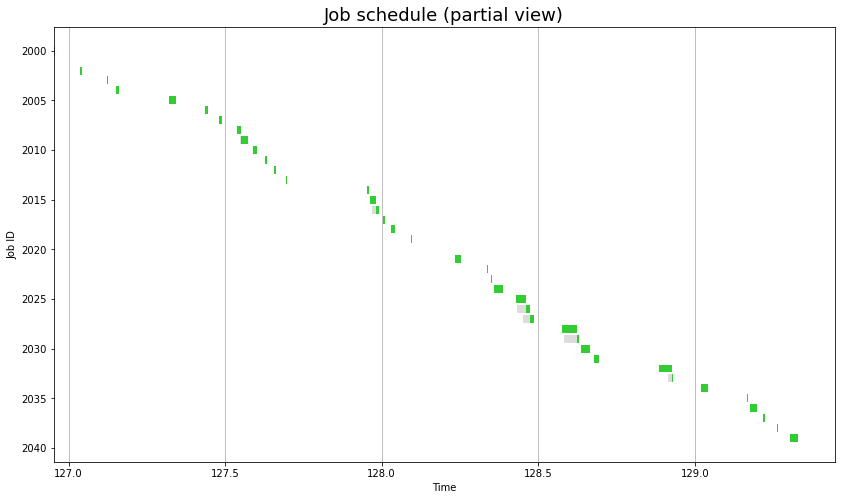

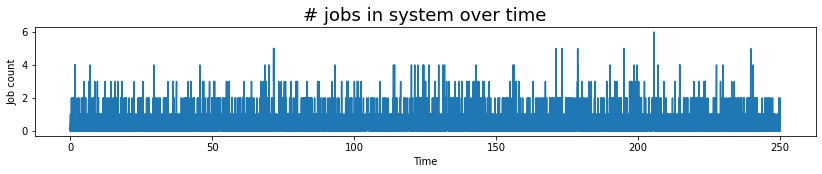

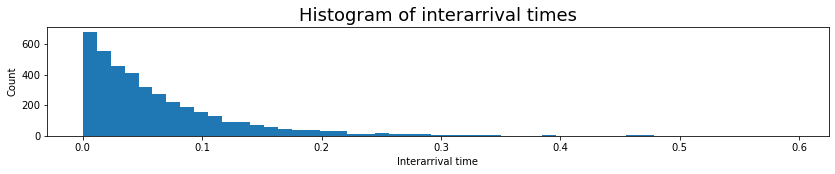

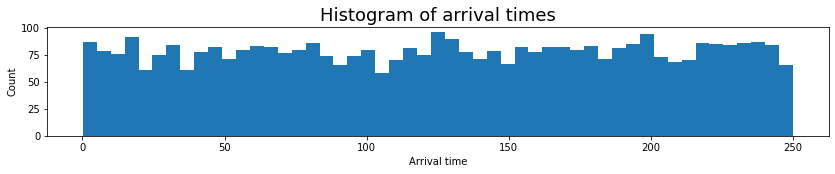

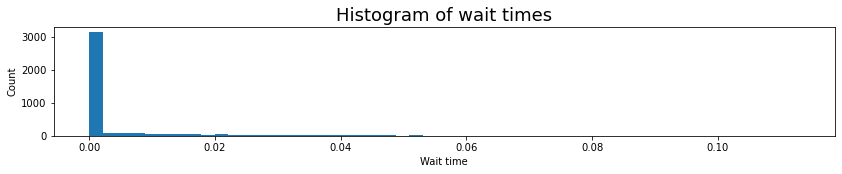

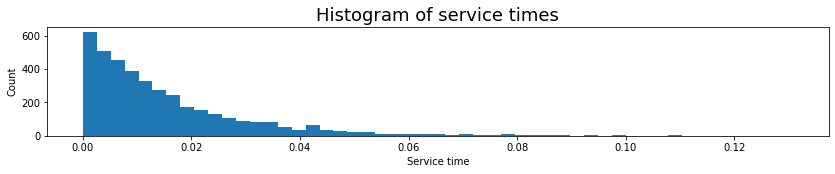

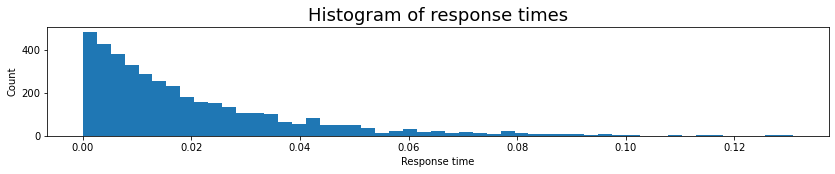

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=32.0000, $1/\lambda$=0.0625, $1/\mu$=0.0312

Simulation statistics
---------------------
total_duration          = 254.6792
arrival_rate_mean       = 15.7136
interarrival_time_mean  = 0.0636
response_time
  mean                  = 0.0646
  var                   = 0.0048
  p50                   = 0.0428
  p75                   = 0.0878
  p90                   = 0.1469
  p95                   = 0.1979
  p99                   = 0.3307
wait_time_mean          = 0.0331
service_rate_mean       = 31.7642
service_time_mean       = 0.0315
num_jobs_in_system_mean = 1.0150
num_jobs_in_queue_mean  = 0.5206
throughput_mean         = 15.6863
utilization             = 0.4945

Little's Law: E[N] = lambda * E[T]
----------------------------------
num_jobs_in_system_mean                = 1.0150
arrival_rate_mean * response_time_mean = 1.0155 (= 15.7136 * 0.0646)

Utilization Law, version 1: rho_i = lambda_i / mu_i
---------------------------------------------------
utilization                            = 0.4945
arrival_rate_mean                  

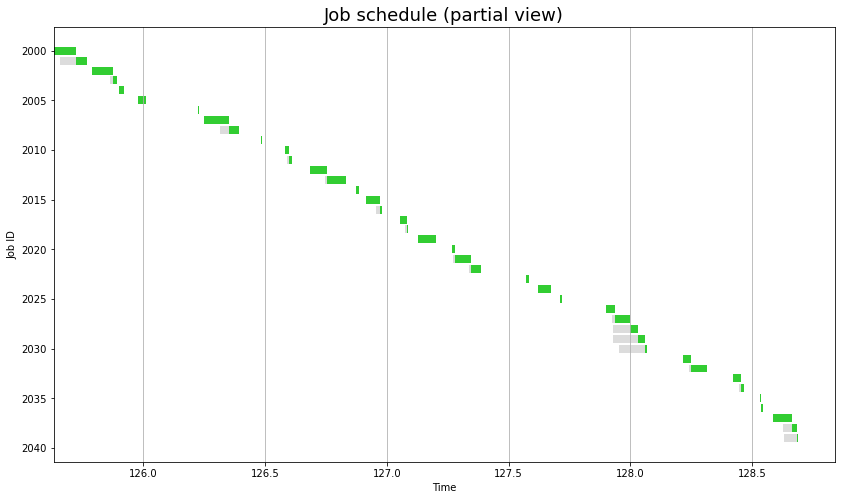

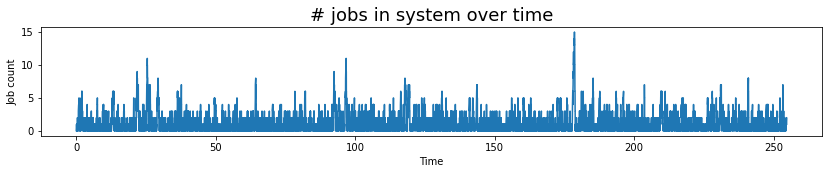

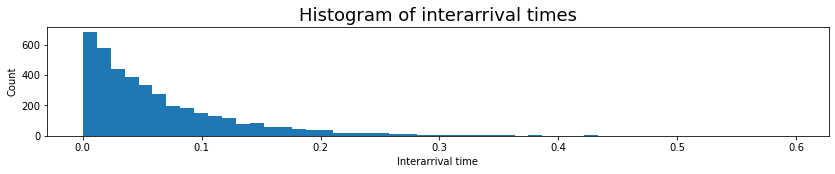

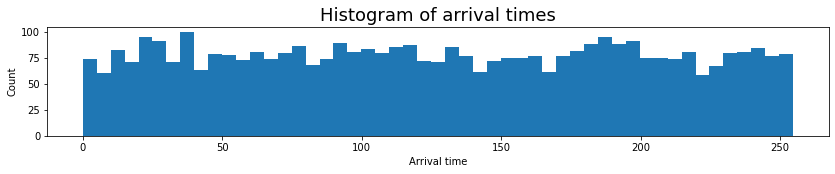

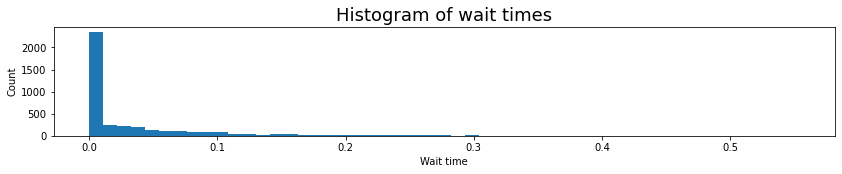

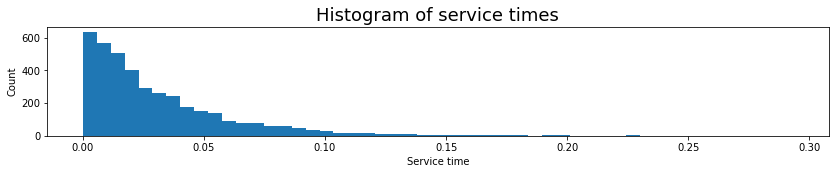

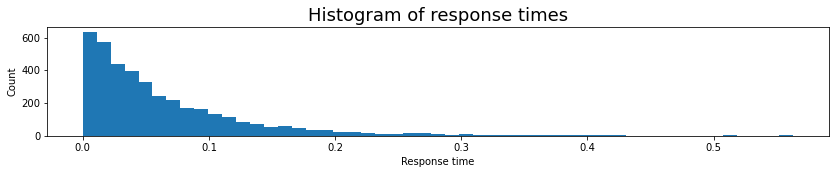

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=18.0000, $1/\lambda$=0.0625, $1/\mu$=0.0556

Simulation statistics
---------------------
total_duration          = 247.8173
arrival_rate_mean       = 16.1498
interarrival_time_mean  = 0.0619
response_time
  mean                  = 0.4744
  var                   = 0.1787
  p50                   = 0.3437
  p75                   = 0.6958
  p90                   = 1.0541
  p95                   = 1.3654
  p99                   = 1.8403
wait_time_mean          = 0.4187
service_rate_mean       = 17.9385
service_time_mean       = 0.0557
num_jobs_in_system_mean = 7.6579
num_jobs_in_queue_mean  = 6.7581
throughput_mean         = 16.1290
utilization             = 0.8998

Little's Law: E[N] = lambda * E[T]
----------------------------------
num_jobs_in_system_mean                = 7.6579
arrival_rate_mean * response_time_mean = 7.6621 (= 16.1498 * 0.4744)

Utilization Law, version 1: rho_i = lambda_i / mu_i
---------------------------------------------------
utilization                            = 0.8998
arrival_rate_mean                  

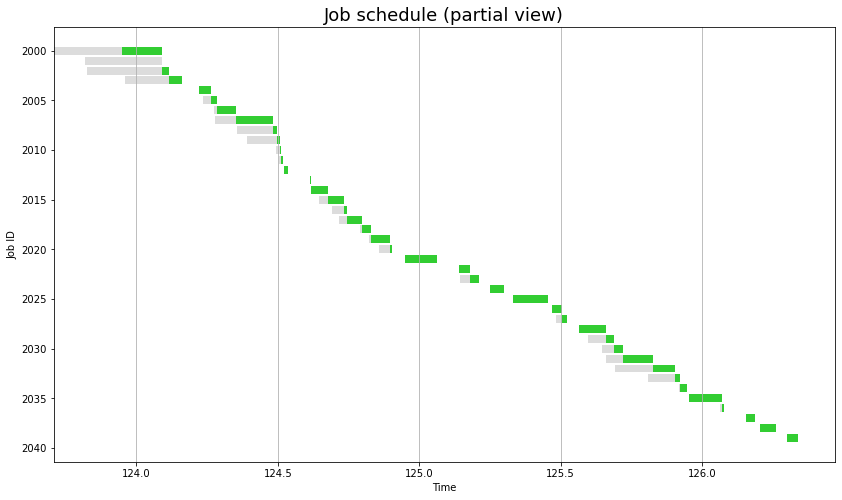

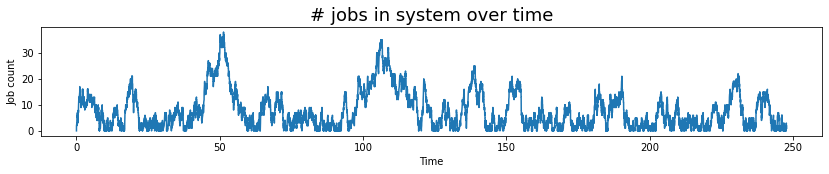

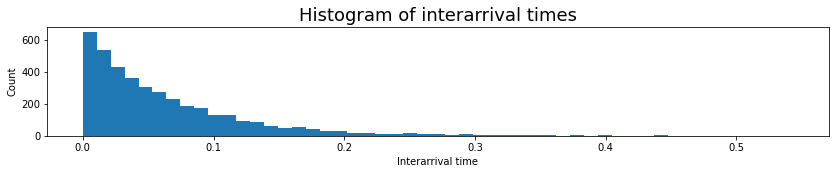

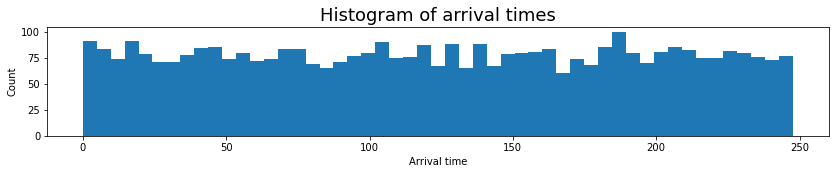

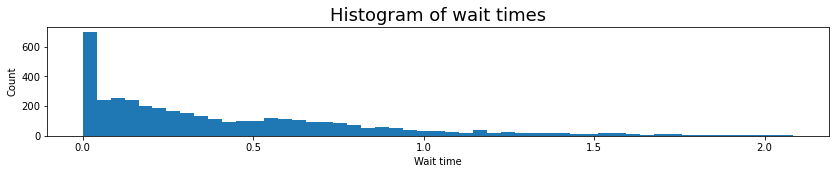

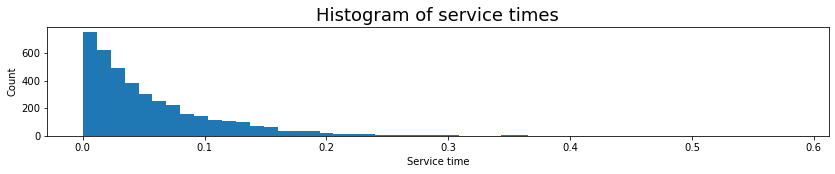

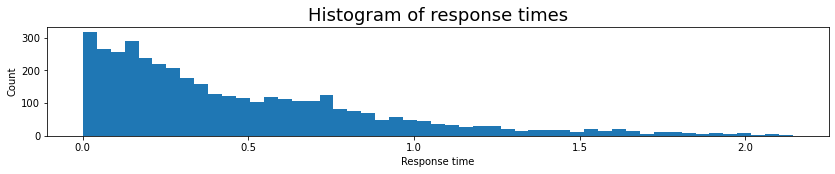

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=16.0000, $1/\lambda$=0.0625, $1/\mu$=0.0625

Simulation statistics
---------------------
total_duration          = 255.9760
arrival_rate_mean       = 16.0617
interarrival_time_mean  = 0.0623
response_time
  mean                  = 4.1179
  var                   = 2.5701
  p50                   = 4.1473
  p75                   = 5.3857
  p90                   = 6.2734
  p95                   = 6.5932
  p99                   = 7.0367
wait_time_mean          = 4.0539
service_rate_mean       = 15.6291
service_time_mean       = 0.0640
num_jobs_in_system_mean = 64.3487
num_jobs_in_queue_mean  = 63.3488
throughput_mean         = 15.6250
utilization             = 0.9998

Little's Law: E[N] = lambda * E[T]
----------------------------------
num_jobs_in_system_mean                = 64.3487
arrival_rate_mean * response_time_mean = 66.1412 (= 16.0617 * 4.1179)

Utilization Law, version 1: rho_i = lambda_i / mu_i
---------------------------------------------------
utilization                            = 0.9998
arrival_rate_mean              

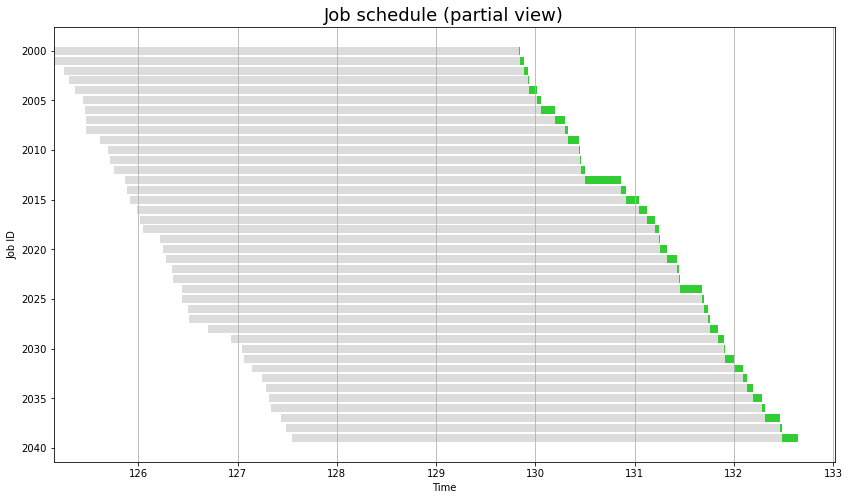

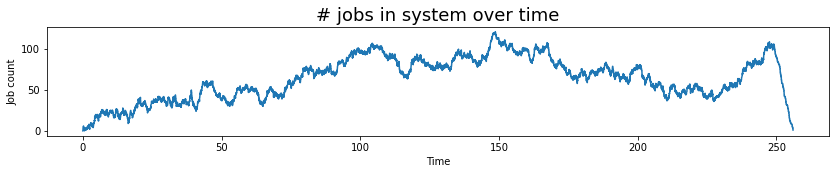

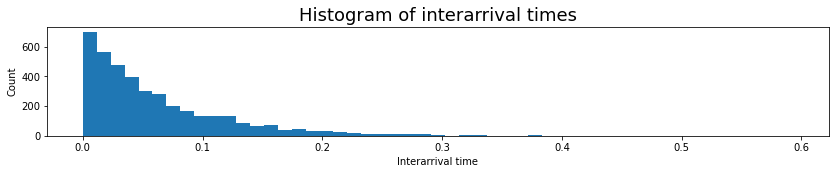

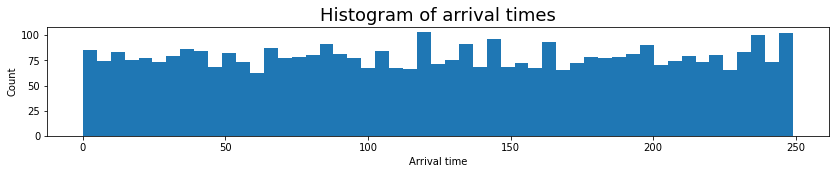

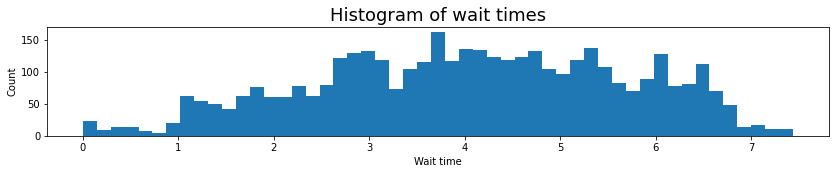

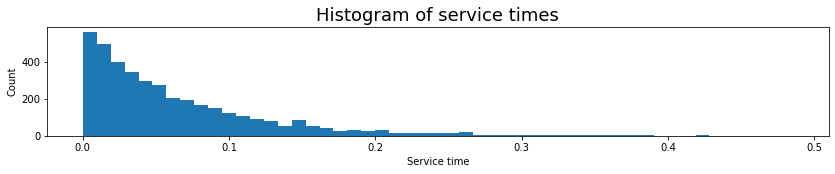

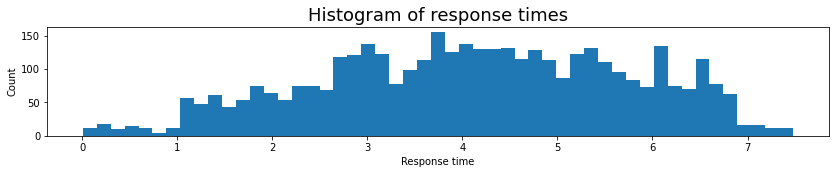

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=15.0000, $1/\lambda$=0.0625, $1/\mu$=0.0667

Simulation statistics
---------------------
total_duration          = 269.3577
arrival_rate_mean       = 16.0300
interarrival_time_mean  = 0.0624
response_time
  mean                  = 11.9850
  var                   = 34.1118
  p50                   = 12.8022
  p75                   = 15.7642
  p90                   = 20.2362
  p95                   = 21.0827
  p99                   = 22.6113
wait_time_mean          = 11.9178
service_rate_mean       = 14.8768
service_time_mean       = 0.0672
num_jobs_in_system_mean = 177.9786
num_jobs_in_queue_mean  = 176.9804
throughput_mean         = 14.8148
utilization             = 0.9982

Little's Law: E[N] = lambda * E[T]
----------------------------------
num_jobs_in_system_mean                = 177.9786
arrival_rate_mean * response_time_mean = 192.1188 (= 16.0300 * 11.9850)

Utilization Law, version 1: rho_i = lambda_i / mu_i
---------------------------------------------------
utilization                            = 0.9982
arrival_rate_mean 

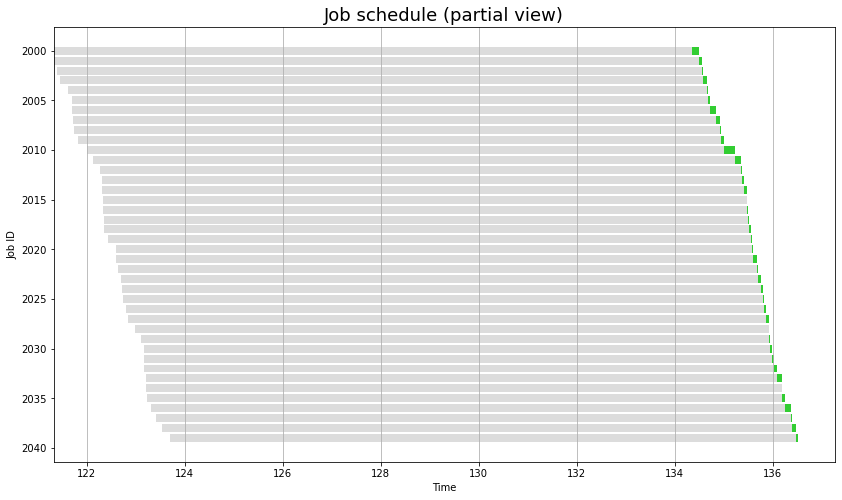

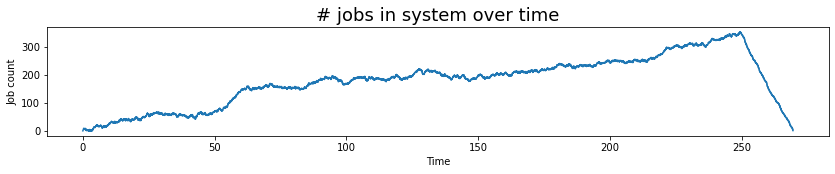

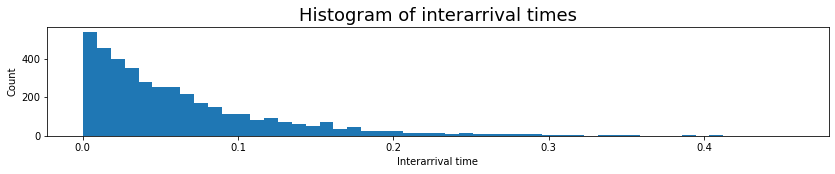

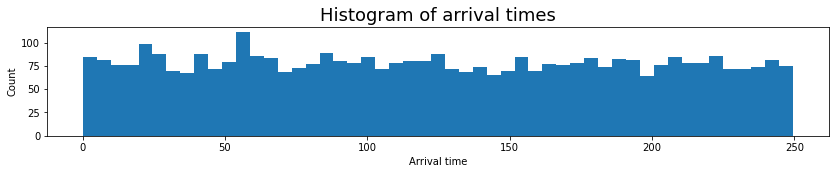

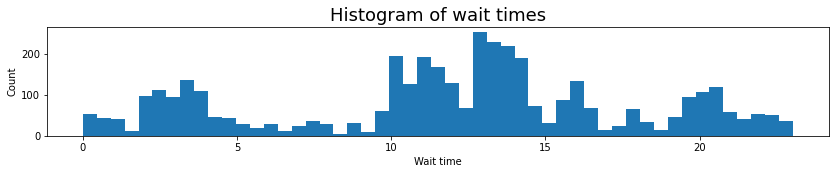

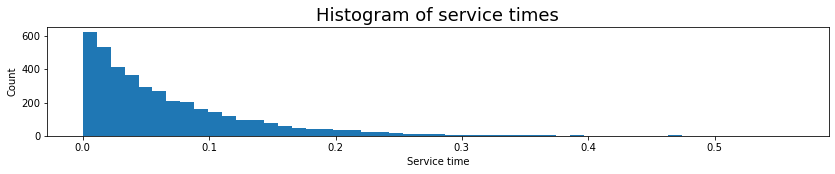

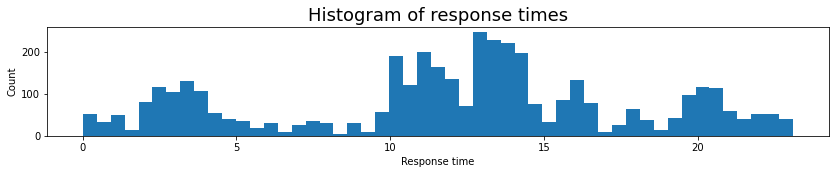

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=12.0000, $1/\lambda$=0.0625, $1/\mu$=0.0833

Simulation statistics
---------------------
total_duration          = 332.7797
arrival_rate_mean       = 15.9335
interarrival_time_mean  = 0.0628
response_time
  mean                  = 40.4630
  var                   = 521.3503
  p50                   = 39.0871
  p75                   = 59.3423
  p90                   = 73.8842
  p95                   = 77.7182
  p99                   = 80.4524
wait_time_mean          = 40.3801
service_rate_mean       = 12.0749
service_time_mean       = 0.0828
num_jobs_in_system_mean = 486.3634
num_jobs_in_queue_mean  = 485.3680
throughput_mean         = 12.0120
utilization             = 0.9955

Little's Law: E[N] = lambda * E[T]
----------------------------------
num_jobs_in_system_mean                = 486.3634
arrival_rate_mean * response_time_mean = 644.7175 (= 15.9335 * 40.4630)

Utilization Law, version 1: rho_i = lambda_i / mu_i
---------------------------------------------------
utilization                            = 0.9955
arrival_rate_mean

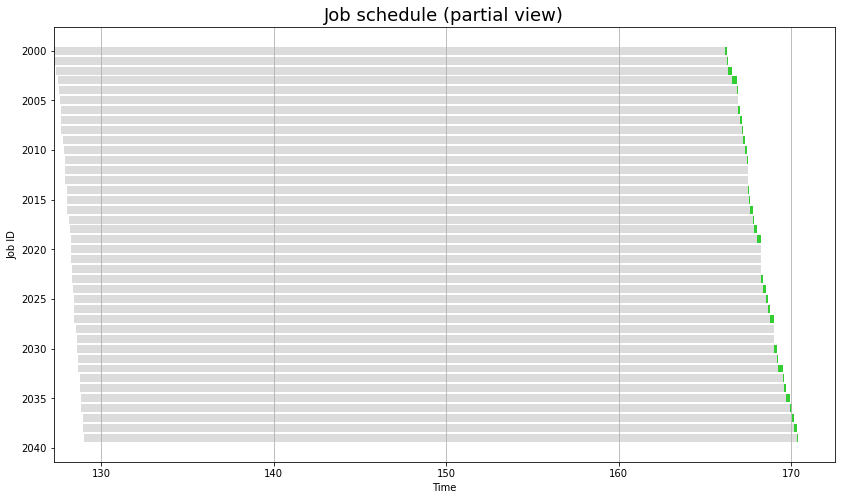

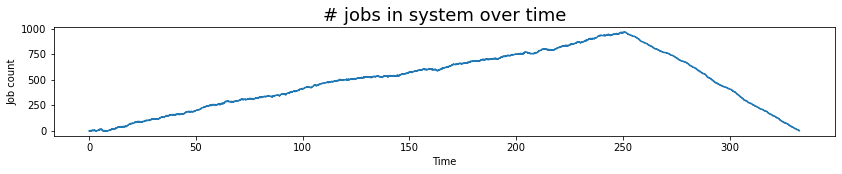

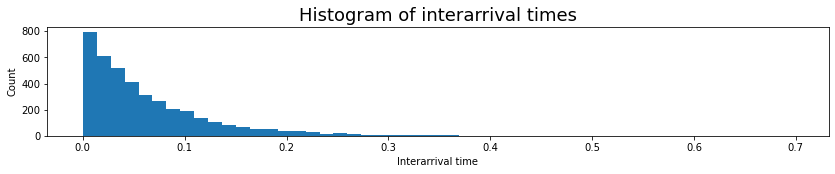

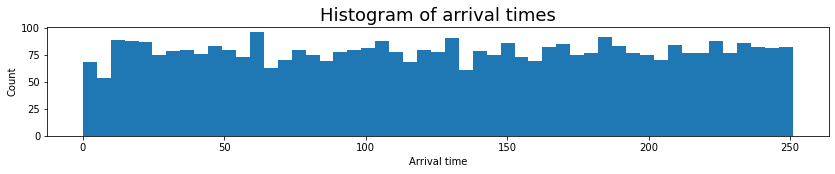

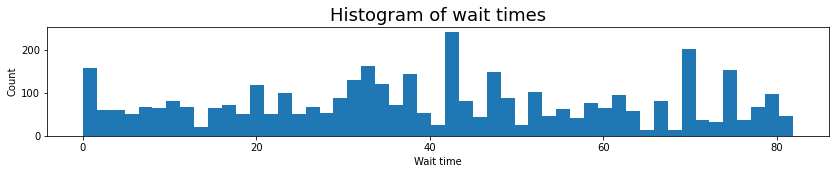

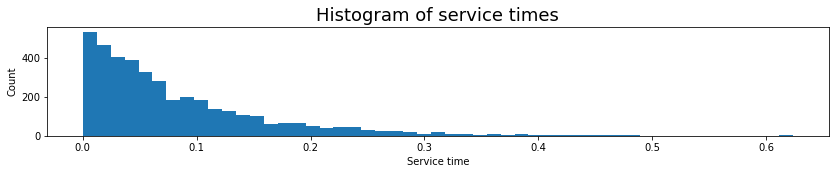

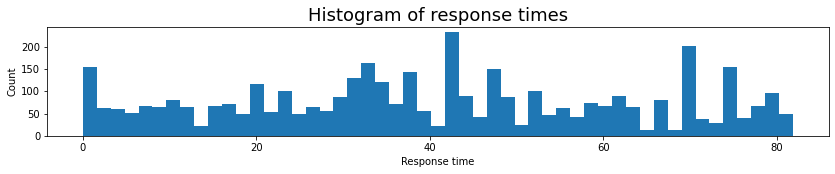

In [6]:
for mu in [64, 32, 18, 16, 15, 12]:
    run_sim_and_plot(4000, 16, mu)